# Customer personality analysis: delves deeper than surface demographics to uncover the motivations, desires, and pain points of customers. By segmenting based on unique traits, businesses can tailor marketing, personalize products, and improve the customer experience.
Benefits:
1. Precision Targeting: Understanding preferences helps target marketing effectively.
2. Product Customization: Insights enable tailored offerings for customer satisfaction.
3. Optimized Marketing Spend: Efficient budget allocation based on analysis.
4. Enhanced Customer Experience: Personalization fosters connections and loyalty.

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Required models for modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.colors import ListedColormap
from sklearn import metrics
import sys
np.random.seed(42)

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading the dataset
customerdata = pd.read_excel("marketing_campaign.xlsx")
print("Number of datapoints:", len(customerdata))
customerdata

Number of datapoints: 2240


ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
0      5524        1957  Graduation         Single  58138.0        0   
1      2174        1954  Graduation         Single  46344.0        1   
2      4141        1965  Graduation       Together  71613.0        0   
3      6182        1984  Graduation       Together  26646.0        1   
4      5324        1981         PhD        Married  58293.0        1   
...     ...         ...         ...            ...      ...      ...   
2235  10870        1967  Graduation        Married  61223.0        0   
2236   4001        1946         PhD       Together  64014.0        2   
2237   7270        1981  Graduation       Divorced  56981.0        0   
2238   8235        1956      Master       Together  69245.0        0   
2239   9405        1954         PhD        Married  52869.0        1   

      Teenhome Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  \
0            0  2012-09-04       58       635  ...                  7   
1            1  2014-03-08       38        11  ...                  5   
2            0  2013-08-21       26       426  ...                  4   
3            0  2014-02-10       26        11  ...                  6   
4            0  2014-01-19       94       173  ...                  5   
...        ...         ...      ...       ...  ...                ...   
2235         1  2013-06-13       46       709  ...                  5   
2236         1  2014-06-10       56       406  ...                  7   
2237         0  2014-01-25       91       908  ...                  6   
2238         1  2014-01-24        8       428  ...                  3   
2239         1  2012-10-15       40        84  ...                  7   

      AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
0                0             0             0             0             0   
1                0             0             0             0             0   
2                0             0             0             0             0   
3                0             0             0             0             0   
4                0             0             0             0             0   
...            ...           ...           ...           ...           ...   
2235             0             0             0             0             0   
2236             0             0             0             1             0   
2237             0             1             0             0             0   
2238             0             0             0             0             0   
2239             0             0             0             0             0   

      Complain  Z_CostContact  Z_Revenue  Response  
0            0              3         11         1  
1            0              3         11         0  
2            0              3         11         0  
3            0              3         11         0  
4            0              3         11         0  
...        ...            ...        ...       ...  
2235         0              3         11         0  
2236         0              3         11         0  
2237         0              3         11         0  
2238         0              3         11         0  
2239         0              3         11         1  

[2240 rows x 29 columns]

In [3]:
customerdata.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

## Data Cleaning

In [4]:
customerdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2240 non-null   int64         
 1   Year_Birth           2240 non-null   int64         
 2   Education            2240 non-null   object        
 3   Marital_Status       2240 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2240 non-null   int64         
 6   Teenhome             2240 non-null   int64         
 7   Dt_Customer          2240 non-null   datetime64[ns]
 8   Recency              2240 non-null   int64         
 9   MntWines             2240 non-null   int64         
 10  MntFruits            2240 non-null   int64         
 11  MntMeatProducts      2240 non-null   int64         
 12  MntFishProducts      2240 non-null   int64         
 13  MntSweetProducts     2240 non-nul

##### From the above output, we can conclude and note that:

##### There are missing values in income
##### Dt_Customer that indicates the date a customer joined the database is not parsed as DateTime
##### There are some categorical features in our data frame; as there are some features in dtype: object). So we will need to encode them into numeric forms later.

In [5]:
# Replace missing values of income feild with Income Mean Values
# Calculate the mean of the 'Income' column
income_mean = customerdata['Income'].mean().round(decimals=0)
income_mean

52247.0

In [6]:
# Replace missing values with the mean
customerdata['Income'].fillna(income_mean, inplace=True)

##### Create a feature out of "Dt_Customer" that indicates the number of days a customer is registered in the firm's database. However, in order to keep it simple, taking this value relative to the most recent customer in the record. Thus to get the values I must check the newest and oldest recorded dates.

In [7]:
# Customer's time being enrolled
customerdata['Dt_Customer'] = pd.to_datetime(customerdata.Dt_Customer)
customerdata['Date_Collected'] = '01-01-2015'
customerdata['Date_Collected'] = pd.to_datetime(customerdata.Date_Collected)
customerdata['Time_Enrolled_Days'] = (customerdata['Date_Collected'] - customerdata['Dt_Customer']).dt.days

In [8]:
print("Total categories in the feature Marital_Status:\n", customerdata["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", customerdata["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64


##### Extract the "Age" of a customer by the "Year_Birth" indicating the birth year of the respective person.
##### Create another feature "Spent" indicating the total amount spent by the customer in various categories over the span of two years.
##### Create another feature "Living_With" out of "Marital_Status" to extract the living situation of couples.
##### Create a feature "Children" to indicate total children in a household that is, kids and teenagers.
##### To get further clarity of household, Creating feature indicating "Family_Size"
##### Create a feature "Is_Parent" to indicate parenthood status
##### Lastly, I will create three categories in the "Education" by simplifying its value counts.
##### Dropping some of the redundant features

# Feature Engineering

In [9]:
#Age of customer today 
customerdata["Age"] = 2024-customerdata["Year_Birth"]

#Total spendings on various items
customerdata["Spent"] = customerdata["MntWines"]+ customerdata["MntFruits"]+ customerdata["MntMeatProducts"]+ customerdata["MntFishProducts"]+ customerdata["MntSweetProducts"]+ customerdata["MntGoldProds"]

#Deriving living situation by marital status"Alone"
customerdata["Living_With"]=customerdata["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
customerdata["Children"]=customerdata["Kidhome"]+customerdata["Teenhome"]

#Feature for total members in the householde
customerdata["Family_Size"] = customerdata["Living_With"].replace({"Alone": 1, "Partner":2})+ customerdata["Children"]

#Feature pertaining parenthood
customerdata["Is_Parent"] = np.where(customerdata.Children> 0, 1, 0)

#Segmenting education levels in three groups
customerdata["Education"]=customerdata["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
customerdata=customerdata.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

In [10]:
customerdata.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish',
       'Sweets', 'Gold', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Date_Collected', 'Time_Enrolled_Days', 'Age', 'Spent', 'Living_With',
       'Children', 'Family_Size', 'Is_Parent'],
      dtype='object')

In [11]:
#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID","Date_Collected"]
customerdata = customerdata.drop(to_drop, axis=1)

In [12]:
# Descriptive Statistics
customerdata.describe()

Income      Kidhome     Teenhome      Recency        Wines  \
count    2240.000000  2240.000000  2240.000000  2240.000000  2240.000000   
mean    52247.248661     0.444196     0.506250    49.109375   303.935714   
std     25037.797168     0.538398     0.544538    28.962453   336.597393   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35538.750000     0.000000     0.000000    24.000000    23.750000   
50%     51741.500000     0.000000     0.000000    49.000000   173.500000   
75%     68289.750000     1.000000     1.000000    74.000000   504.250000   
max    666666.000000     2.000000     2.000000    99.000000  1493.000000   

            Fruits         Meat         Fish       Sweets         Gold  ...  \
count  2240.000000  2240.000000  2240.000000  2240.000000  2240.000000  ...   
mean     26.302232   166.950000    37.525446    27.062946    44.021875  ...   
std      39.773434   225.715373    54.628979    41.280498    52.167439  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       1.000000    16.000000     3.000000     1.000000     9.000000  ...   
50%       8.000000    67.000000    12.000000     8.000000    24.000000  ...   
75%      33.000000   232.000000    50.000000    33.000000    56.000000  ...   
max     199.000000  1725.000000   259.000000   263.000000   362.000000  ...   

       AcceptedCmp1  AcceptedCmp2     Complain     Response  \
count   2240.000000   2240.000000  2240.000000  2240.000000   
mean       0.064286      0.013393     0.009375     0.149107   
std        0.245316      0.114976     0.096391     0.356274   
min        0.000000      0.000000     0.000000     0.000000   
25%        0.000000      0.000000     0.000000     0.000000   
50%        0.000000      0.000000     0.000000     0.000000   
75%        0.000000      0.000000     0.000000     0.000000   
max        1.000000      1.000000     1.000000     1.000000   

       Time_Enrolled_Days          Age        Spent     Children  Family_Size  \
count         2240.000000  2240.000000  2240.000000  2240.000000  2240.000000   
mean           539.582143    55.194196   605.798214     0.950446     2.595089   
std            202.122512    11.984069   602.249288     0.751803     0.906959   
min            186.000000    28.000000     5.000000     0.000000     1.000000   
25%            366.750000    47.000000    68.750000     0.000000     2.000000   
50%            541.500000    54.000000   396.000000     1.000000     3.000000   
75%            715.000000    65.000000  1045.500000     1.000000     3.000000   
max            885.000000   131.000000  2525.000000     3.000000     5.000000   

         Is_Parent  
count  2240.000000  
mean      0.715179  
std       0.451430  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max       1.000000  

[8 rows x 28 columns]

##### The above stats show some discrepancies in mean Income and Age and max Income and age.

##### Do note that max-age is 131 years, As I calculated the age that would be today (i.e. 2024) and the data is old.

##### It clearly says there are outliers in Income and age, taking only those data points which falls under 3 standard deviation.

Text(0.5, 1.0, 'Income chart of customers')

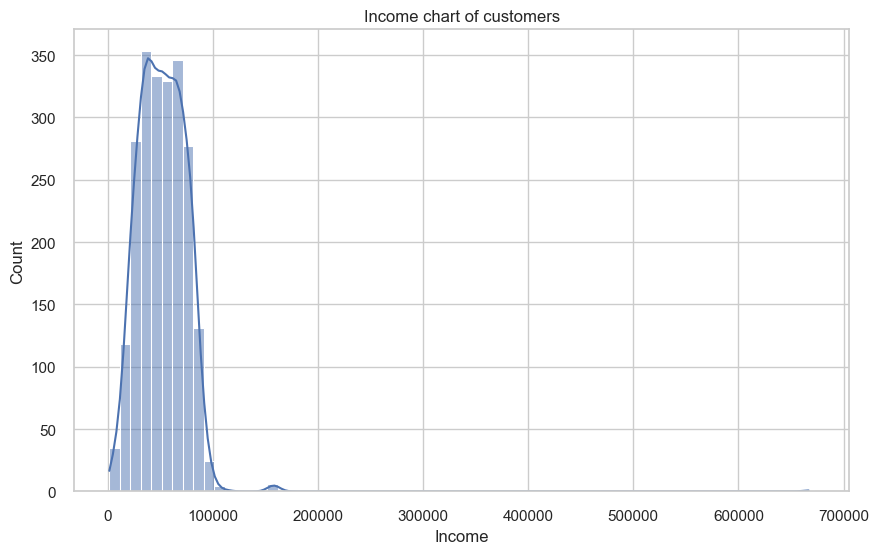

In [13]:
plt.figure(figsize=(10,6))
sns.set(style='whitegrid')
ax = sns.histplot(data=customerdata, x='Income', binwidth=10000, kde=True)
ax.set_title('Income chart of customers')

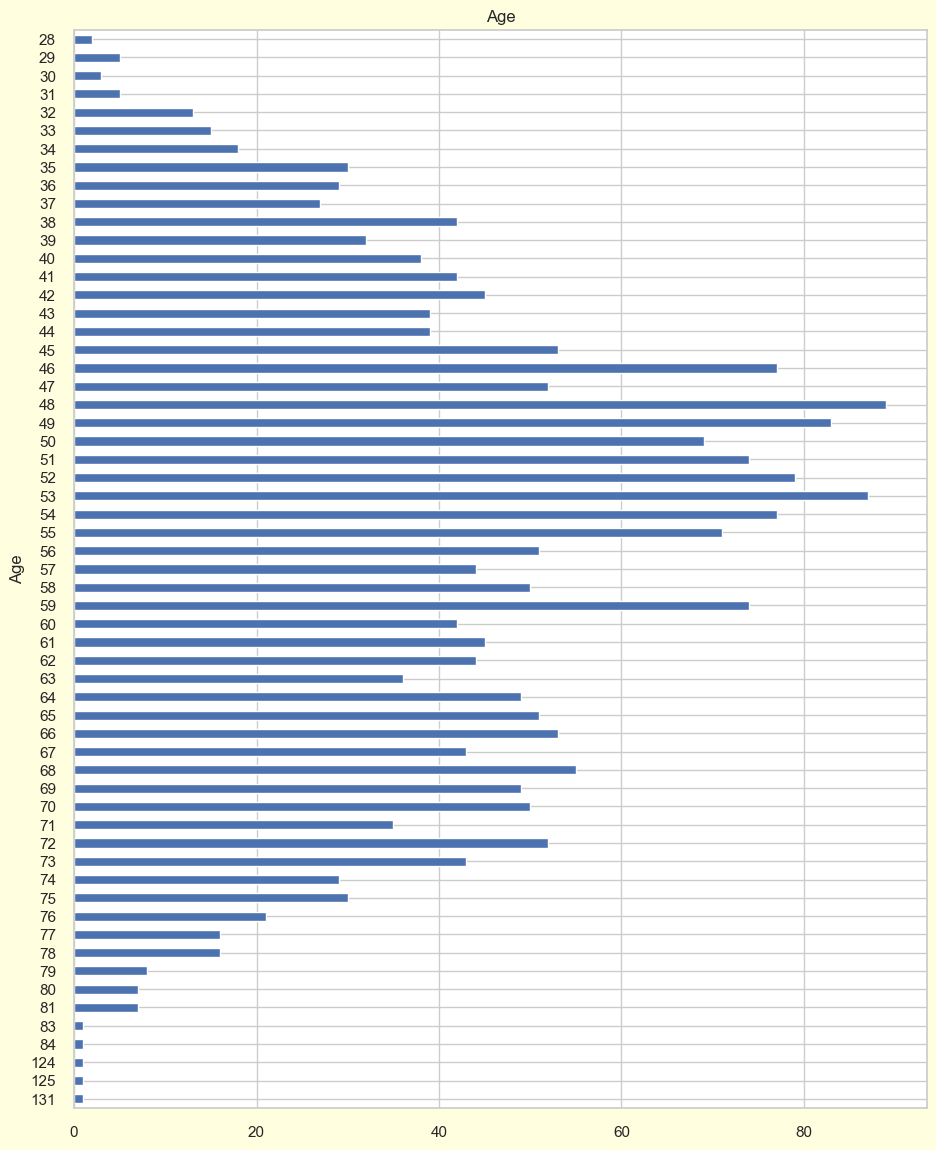

In [14]:
plt.figure(figsize=(11,14), facecolor='lightyellow')
customerdata['Age'].value_counts().sort_index(ascending=False).plot(kind='barh')
plt.title('Age')
plt.show()

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

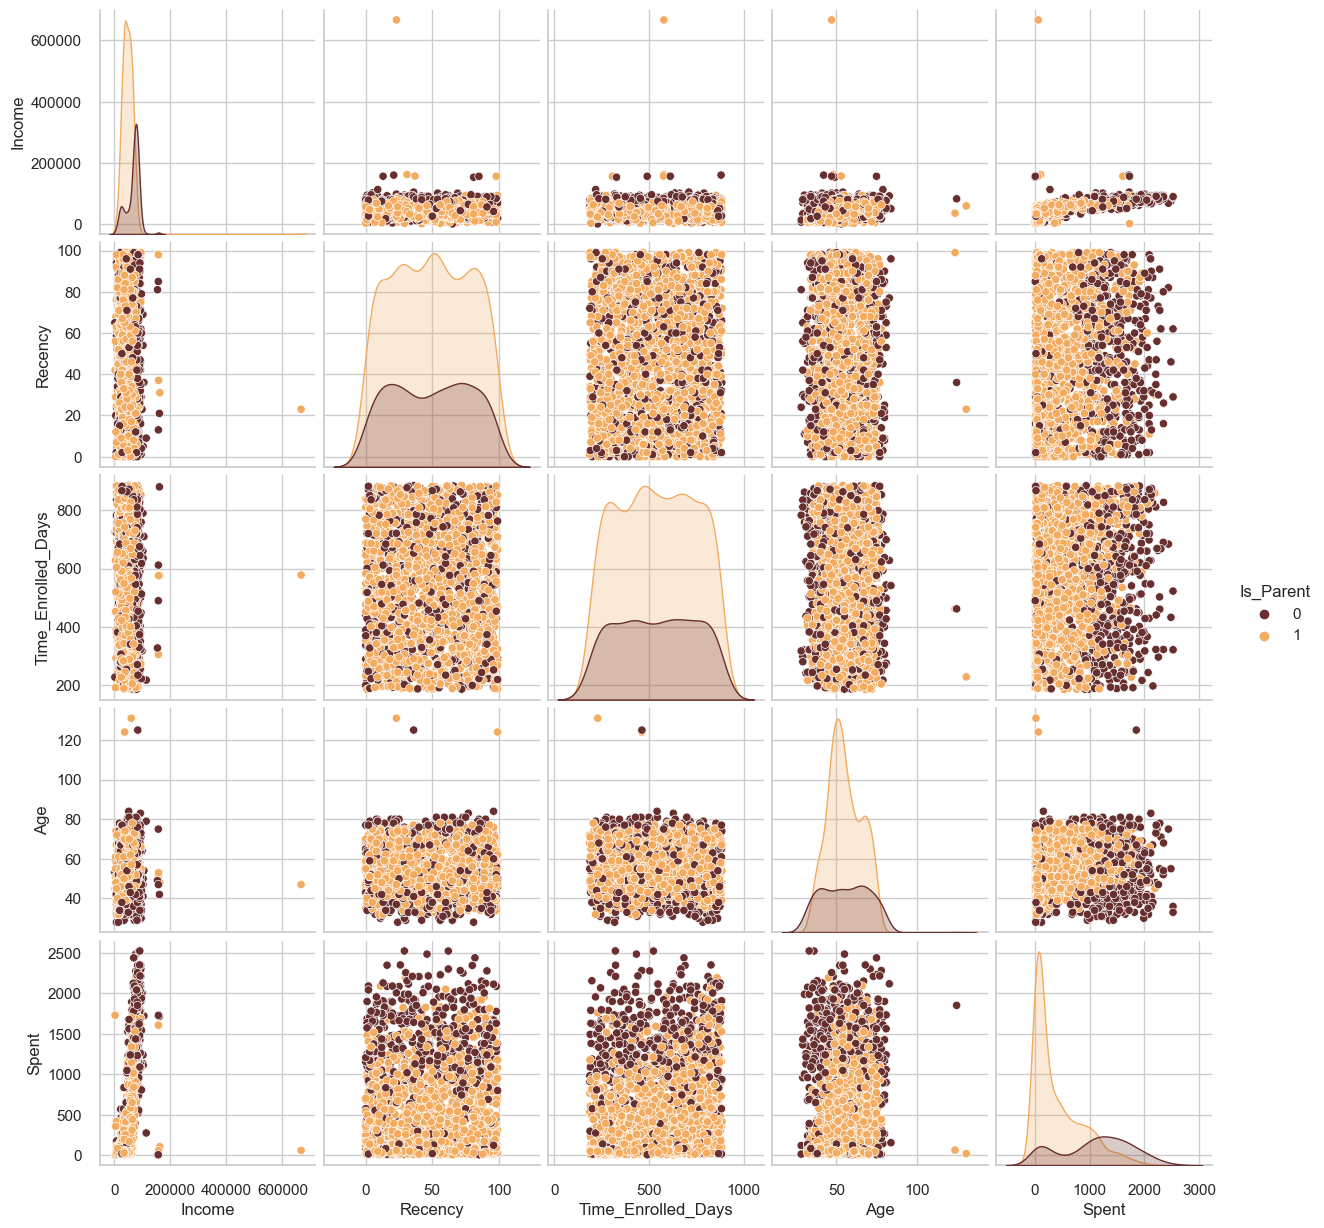

In [15]:
#Plotting following features
To_Plot = [ "Income", "Recency", "Time_Enrolled_Days", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(customerdata[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

##### There are a few outliers in the Income and Age features.Deleting the outliers in the customer data.

In [16]:
# Removing outliers in income
from scipy import stats
# Remove observation with more than 3 in Z score
customerdata = customerdata[(np.abs(stats.zscore(customerdata['Income'])) < 3)]     

# Reset index
customerdata.reset_index(inplace=True)                          

customerdata = customerdata.drop(columns=['index'])

In [17]:
customerdata.shape

(2232, 30)

<Axes: >

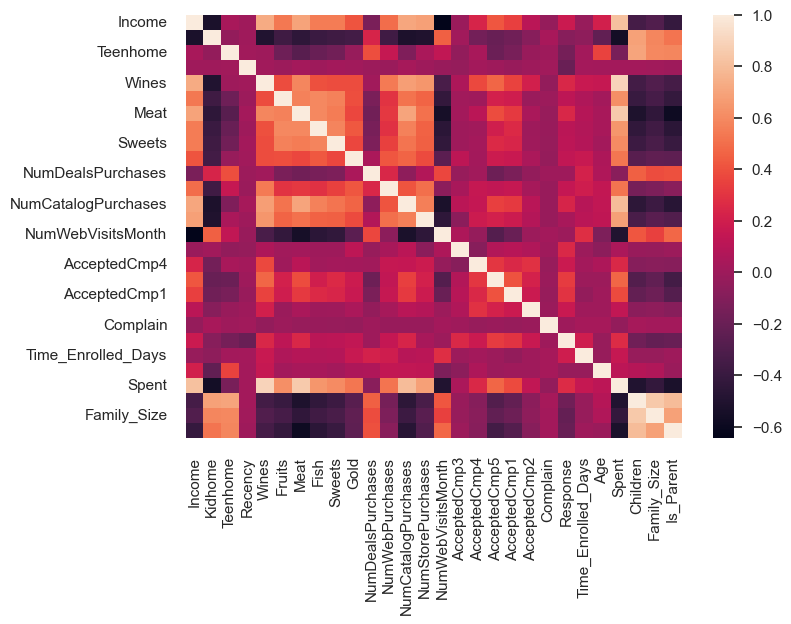

In [18]:
sns.heatmap(customerdata.select_dtypes(include=[np.number]).corr())

# Data preprocessing

In [19]:
#Get list of categorical variables
s = (customerdata.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [20]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    customerdata[i]=customerdata[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [21]:
customerdata.head()

Education   Income  Kidhome  Teenhome  Recency  Wines  Fruits  Meat  Fish  \
0          0  58138.0        0         0       58    635      88   546   172   
1          0  46344.0        1         1       38     11       1     6     2   
2          0  71613.0        0         0       26    426      49   127   111   
3          0  26646.0        1         0       26     11       4    20    10   
4          1  58293.0        1         0       94    173      43   118    46   

   Sweets  ...  AcceptedCmp2  Complain  Response  Time_Enrolled_Days  Age  \
0      88  ...             0         0         1                 849   67   
1       1  ...             0         0         0                 299   70   
2      21  ...             0         0         0                 498   59   
3       3  ...             0         0         0                 325   40   
4      27  ...             0         0         0                 347   43   

   Spent  Living_With  Children  Family_Size  Is_Parent  
0   1617            0         0            1          0  
1     27            0         2            3          1  
2    776            1         0            2          0  
3     53            1         1            3          1  
4    422            1         1            3          1  

[5 rows x 30 columns]

# Standardization

In [22]:
customerdata.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
       'Time_Enrolled_Days', 'Age', 'Spent', 'Living_With', 'Children',
       'Family_Size', 'Is_Parent'],
      dtype='object')

In [23]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customerdata)

# PCA

In [24]:
# Perform dimensionality reduction (if needed)
pca = PCA(n_components=12)  # Assuming you want to reduce the dimensions to 12
X_pca = pca.fit_transform(X_scaled)

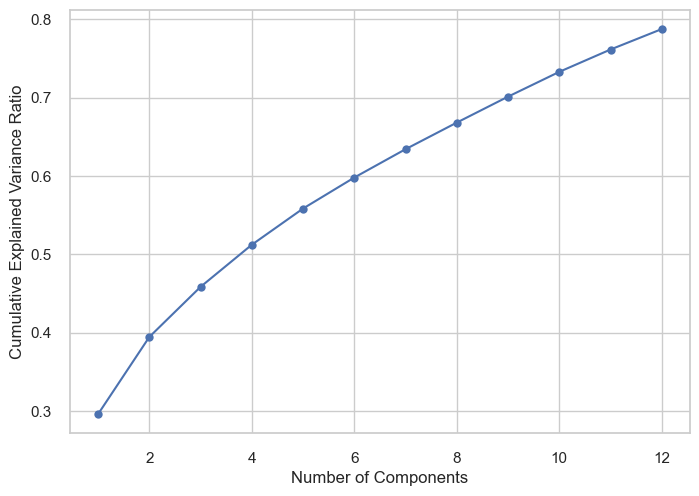

In [25]:
import matplotlib.pyplot as plt

# Get explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

# Perform Clustering

### Elbow Method to determine the number of clusters to be formed
### Model evaluation using Silhouette score

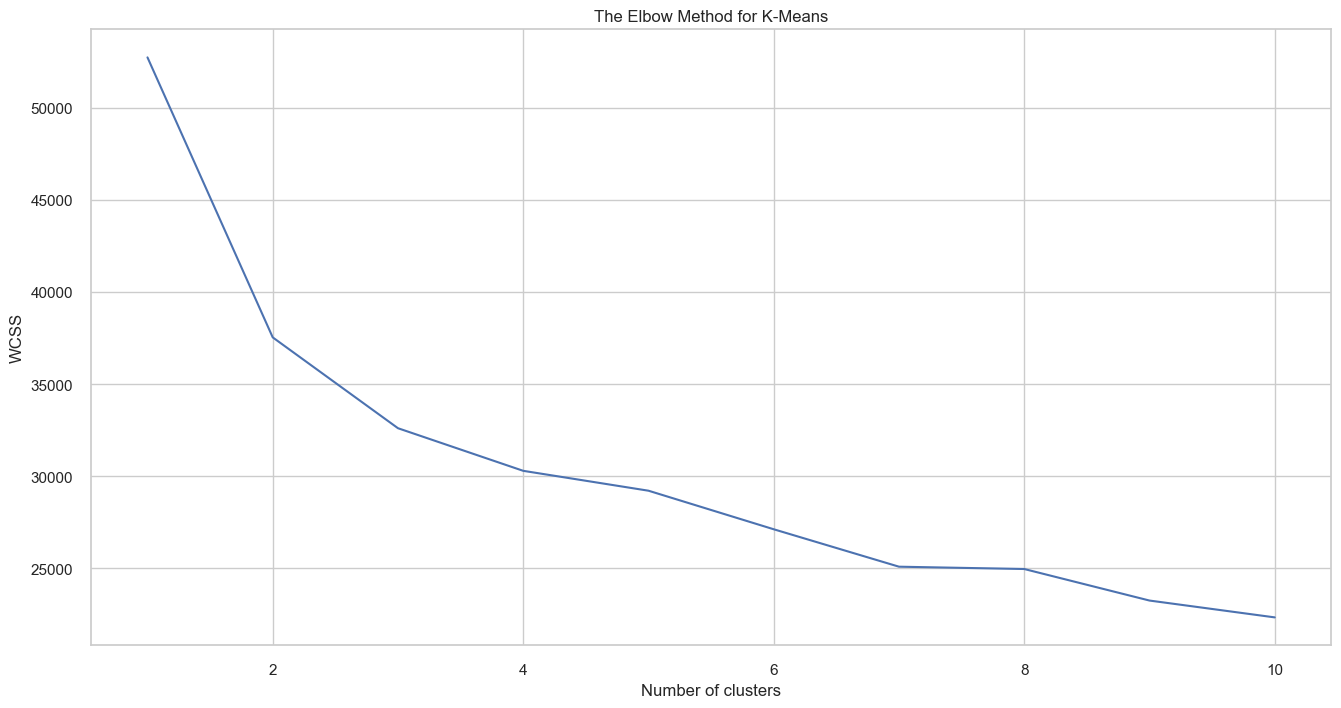

In [26]:
from sklearn.cluster import KMeans
wcss=[]
for i in range (1,11):
 kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42)
 kmeans.fit(X_pca)
 wcss.append(kmeans.inertia_)
plt.figure(figsize=(16,8))
plt.plot(range(1,11),wcss, 'bx-')
plt.title('The Elbow Method for K-Means')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#### From above graph we can choose number of clusters as 4. Lets see for silhouette score for more details.

In [27]:
# Elbow_M = KElbowVisualizer(KMeans(), k=(2,10), metric='silhouette')
# Elbow_M.fit(X_pca)
# Elbow_M.show();

In [30]:
 from sklearn.metrics import silhouette_score
# min_clusters = 2
# max_clusters = 10
# cluster_range = range(min_clusters, max_clusters + 1)

# # Initialize lists to store silhouette scores
silhouette_scores = []

# # Calculate Silhouette Score for each number of clusters
# for k in cluster_range:
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(X_pca)
#     labels = kmeans.labels_
#     silhouette_avg = silhouette_score(X_pca, labels)
#     silhouette_scores.append(silhouette_avg)
#     print("The cluster:", k , "average silhouette score is:", silhouette_avg)
# # Plot Silhouette Scores versus number of clusters
# plt.plot(cluster_range, silhouette_scores, marker='o')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Score vs. Number of Clusters')
# plt.xticks(cluster_range)
# plt.grid(True)

# # Find the index of the maximum silhouette score
# max_index = np.argmax(silhouette_scores)

# # Annotate the elbow point
# plt.annotate('Elbow Point', xy=(cluster_range[max_index], silhouette_scores[max_index]),
#              xytext=(cluster_range[max_index] - 1, silhouette_scores[max_index] + 0.02),
#              arrowprops=dict(facecolor='black', arrowstyle='->'))

# plt.show()

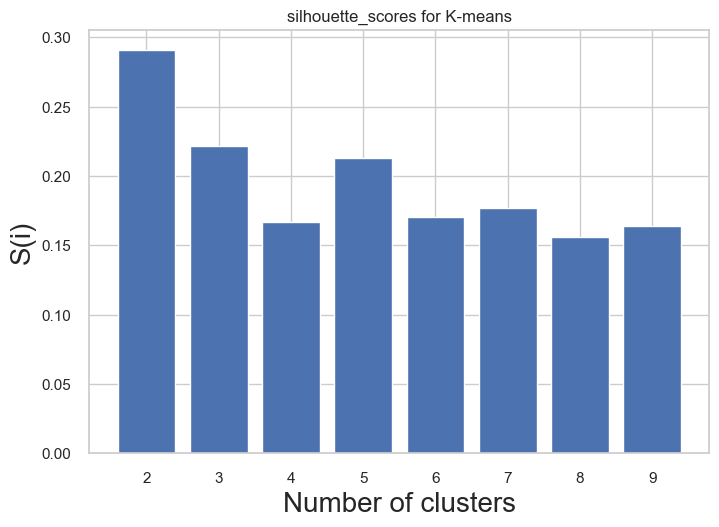

In [31]:
silhouette_scores = []
for i in range(2,10):
    m1=KMeans(n_clusters=i, random_state=42)
    c = m1.fit_predict(X_pca)
    silhouette_scores.append(silhouette_score(X_pca, m1.fit_predict(X_pca))) 
plt.bar(range(2,10), silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.title("silhouette_scores for K-means")
plt.show()

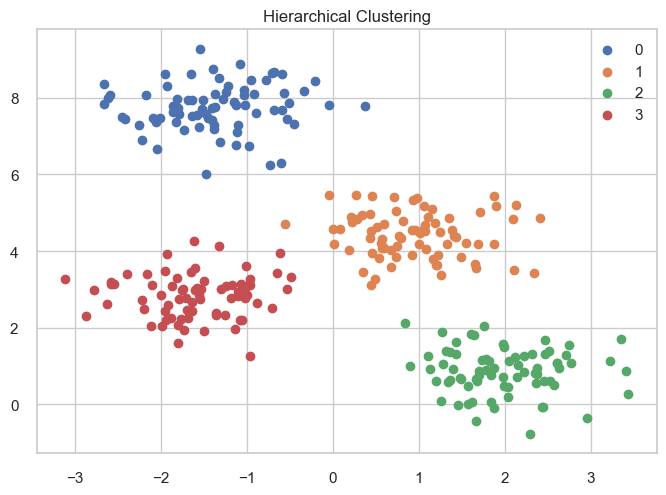

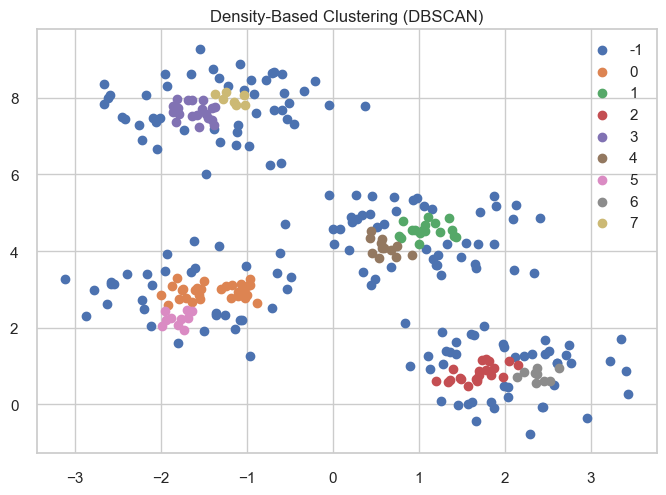

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, DBSCAN

# Generating sample data
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Hierarchical clustering (Agglomerative Clustering)
def hierarchical_clustering(X):
    # Creating Agglomerative Clustering model
    agg_cluster = AgglomerativeClustering(n_clusters=4)
    # Fitting model and predicting clusters
    agg_labels = agg_cluster.fit_predict(X)
    return agg_labels

# Density-based clustering (DBSCAN)
def density_based_clustering(X):
    # Creating DBSCAN model
    dbscan = DBSCAN(eps=0.3, min_samples=10)
    # Fitting model and predicting clusters
    dbscan_labels = dbscan.fit_predict(X)
    return dbscan_labels

# Plotting the clusters
def plot_clusters(X, labels, title):
    unique_labels = np.unique(labels)
    for i in unique_labels:
        plt.scatter(X[labels == i , 0] , X[labels == i , 1] , label = i)
    plt.title(title)
    plt.legend()
    plt.show()

# Hierarchical clustering
agg_labels = hierarchical_clustering(X)
plot_clusters(X, agg_labels, title="Hierarchical Clustering")

# Density-based clustering
dbscan_labels = density_based_clustering(X)
plot_clusters(X, dbscan_labels, title="Density-Based Clustering (DBSCAN)")


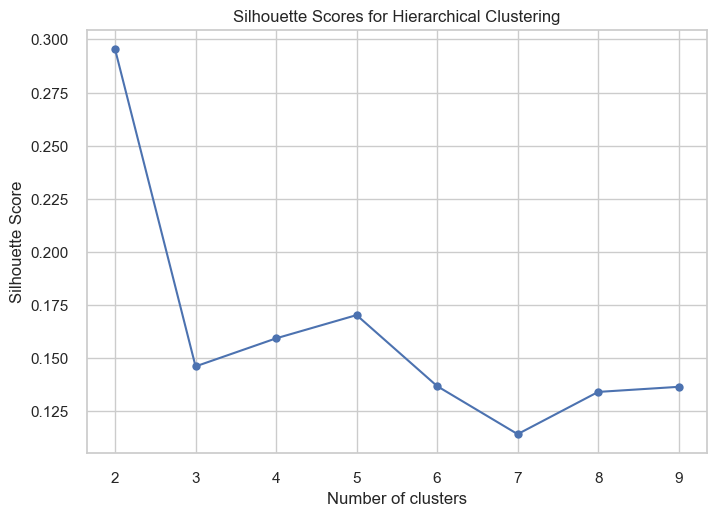

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# # Generating sample data
# X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# # Performing PCA for dimensionality reduction (optional)
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# Calculate silhouette scores for hierarchical clustering
def calculate_hierarchical_silhouette_scores(X):
    silhouette_scores = []
    for n_clusters in range(2, 10):
        agg_cluster = AgglomerativeClustering(n_clusters=n_clusters)
        agg_labels = agg_cluster.fit_predict(X)
        silhouette_scores.append((silhouette_score(X, agg_labels), n_clusters))
    return silhouette_scores

# Plot silhouette scores for hierarchical clustering
def plot_hierarchical_silhouette_scores(scores):
    silhouette_scores, n_clusters_values = zip(*scores)
    plt.plot(n_clusters_values, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters', fontsize=12)
    plt.ylabel('Silhouette Score', fontsize=12)
    plt.title('Silhouette Scores for Hierarchical Clustering')
    plt.show()

# Calculate silhouette scores
hierarchical_scores = calculate_hierarchical_silhouette_scores(X_pca)

# Plot silhouette scores
plot_hierarchical_silhouette_scores(hierarchical_scores)

#### Although score of 3_clusters to 5_clusters is decent  silhouette_score however we are choosing 3_clusters because observations seems to be more evenly distributed among the clusters and making stratgey for 3 cluster is much more convinient and silhouette scores are droping after cluster 3 Scores 

In [34]:
customerdata.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
       'Time_Enrolled_Days', 'Age', 'Spent', 'Living_With', 'Children',
       'Family_Size', 'Is_Parent'],
      dtype='object')

# K-Means Clustering

##### KMeans is a popular unsupervised learning algorithm used for clustering. The algorithm works by dividing a set of observations into a predetermined number of clusters. The number of clusters is determined by the user before the algorithm is run. KMeans clustering works by first randomly initializing a set of centroids for each cluster. The centroids are points that represent the center of each cluster. The algorithm then iteratively assigns each observation to its closest centroid and updates the centroid position based on the new assignments. The algorithm repeats this process until the centroids no longer move or a maximum number of iterations is reached.

In [35]:
from scipy.cluster.hierarchy import fcluster, linkage
import joblib

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_pca)

KMeans(n_clusters=3, random_state=42)

In [36]:
# Predict KMeans cluster
cluster_labels_kmeans = kmeans.predict(X_pca)

In [37]:
# Save the scaler and cluster labels
joblib.dump((scaler, kmeans), 'kmeans_clustering_model.pkl')

['kmeans_clustering_model.pkl']

In [38]:
# Add cluster labels to the original dataset
customerdata['KMeans_Cluster'] = cluster_labels_kmeans

In [39]:
# Analyze the characteristics of each cluster
K_cluster_means = customerdata.groupby('KMeans_Cluster').mean()
print(K_cluster_means)

                Education        Income   Kidhome  Teenhome    Recency  \
KMeans_Cluster                                                           
0                0.555380  60155.973101  0.215190  0.971519  48.409810   
1                0.665434  35209.167283  0.781885  0.460259  49.374307   
2                0.567568  75571.635135  0.019305  0.038610  49.416988   

                     Wines     Fruits        Meat       Fish     Sweets  ...  \
KMeans_Cluster                                                           ...   
0               484.863924  30.876582  161.357595  40.414557  31.859177  ...   
1                47.378004   5.157116   25.352126   7.774492   5.320702  ...   
2               623.372587  65.225869  462.517375  96.658301  67.025097  ...   

                AcceptedCmp2  Complain  Response  Time_Enrolled_Days  \
KMeans_Cluster                                                         
0                   0.012658  0.007911  0.106013          589.109177   
1           

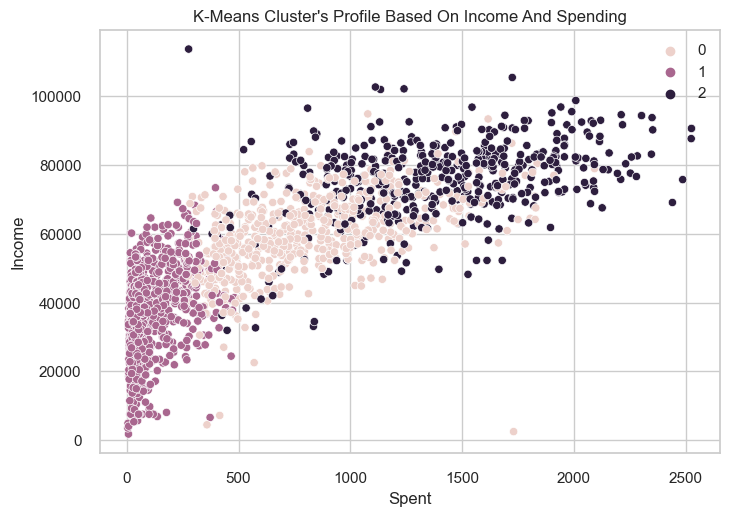

In [40]:
pl = sns.scatterplot(data = customerdata,x=customerdata["Spent"], y=customerdata["Income"],hue=customerdata["KMeans_Cluster"])
pl.set_title("K-Means Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

In [41]:
kmeans.n_clusters

3

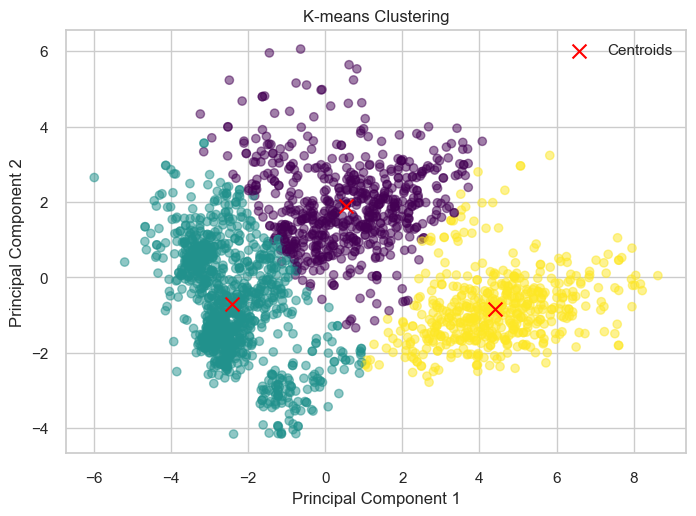

In [42]:
# Plot the data points colored by predicted cluster labels
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=customerdata['KMeans_Cluster'], cmap='viridis',
            marker='o', alpha=0.5)

# Plot cluster centroids (if available)
plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 1], c='red',
            marker='x', s=100, label='Centroids')

plt.title('K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


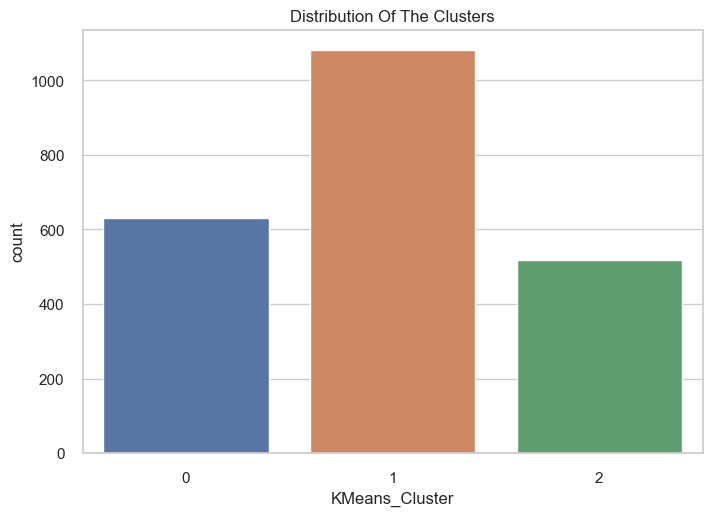

In [43]:
pl = sns.countplot(x=customerdata["KMeans_Cluster"])
pl.set_title("Distribution Of The Clusters")
plt.show()

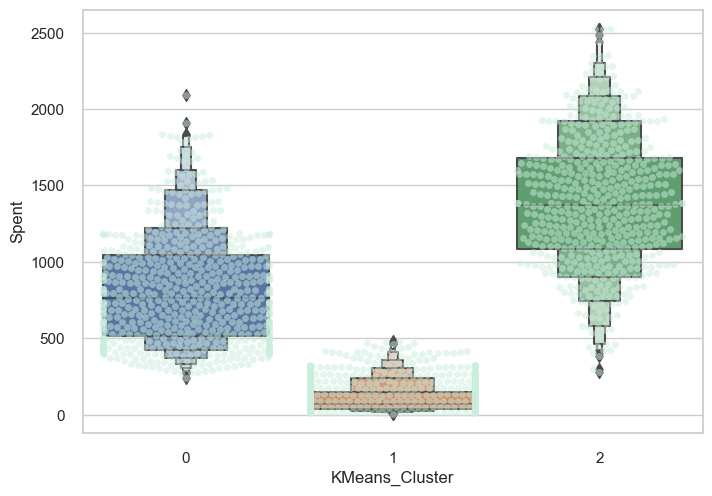

In [44]:
plt.figure()
pl=sns.swarmplot(x=customerdata["KMeans_Cluster"], y=customerdata["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=customerdata["KMeans_Cluster"], y=customerdata["Spent"])
plt.show()

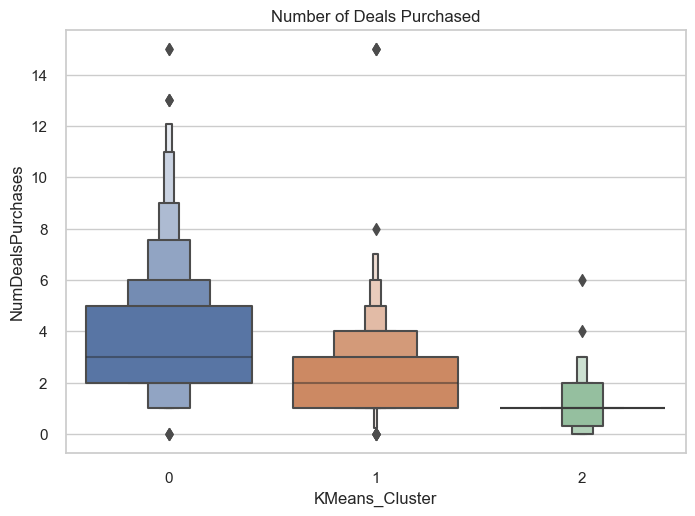

In [45]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=customerdata["NumDealsPurchases"],x=customerdata["KMeans_Cluster"])
pl.set_title("Number of Deals Purchased")
plt.show()

<Figure size 800x550 with 0 Axes>

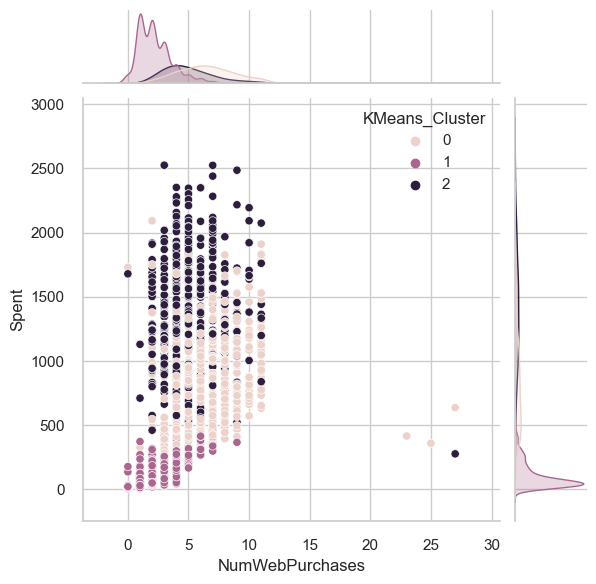

<Figure size 800x550 with 0 Axes>

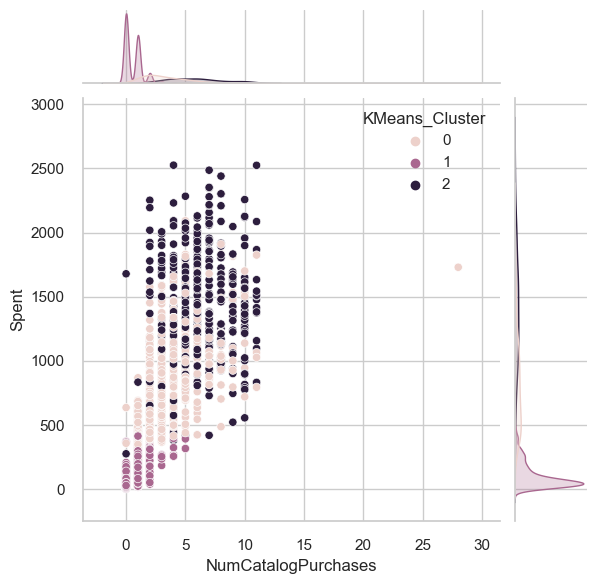

<Figure size 800x550 with 0 Axes>

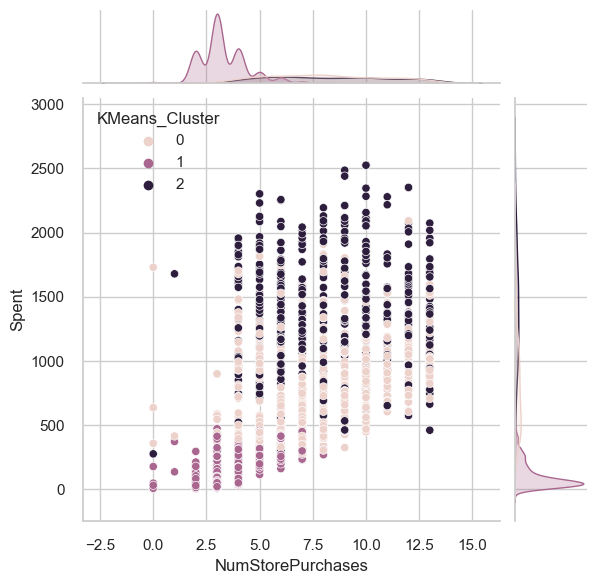

<Figure size 800x550 with 0 Axes>

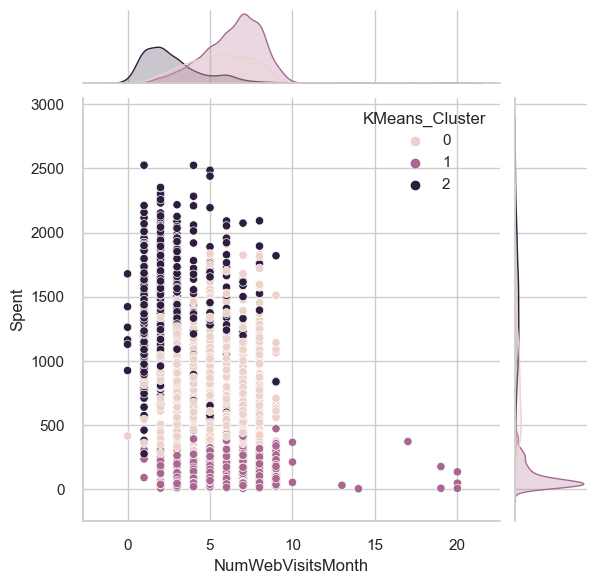

In [46]:
#for more details on the purchasing style 
Places =["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases",  "NumWebVisitsMonth"] 

for i in Places:
    plt.figure()
    sns.jointplot(x=customerdata[i],y = customerdata["Spent"],hue=customerdata["KMeans_Cluster"])
    plt.show()

### Profiling Clustering

<Figure size 800x550 with 0 Axes>

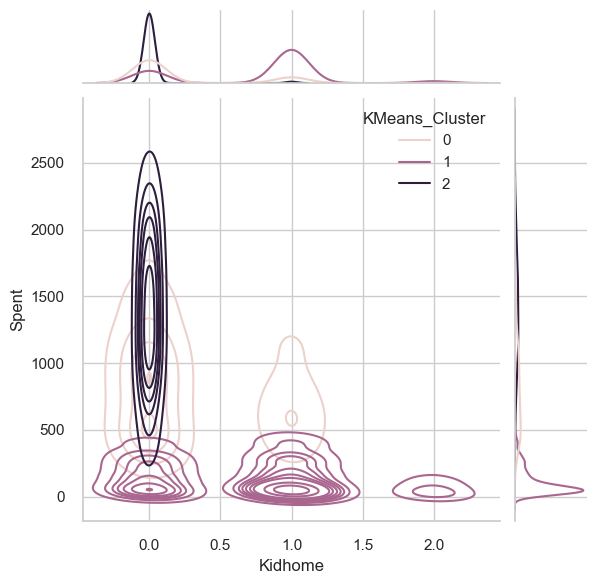

<Figure size 800x550 with 0 Axes>

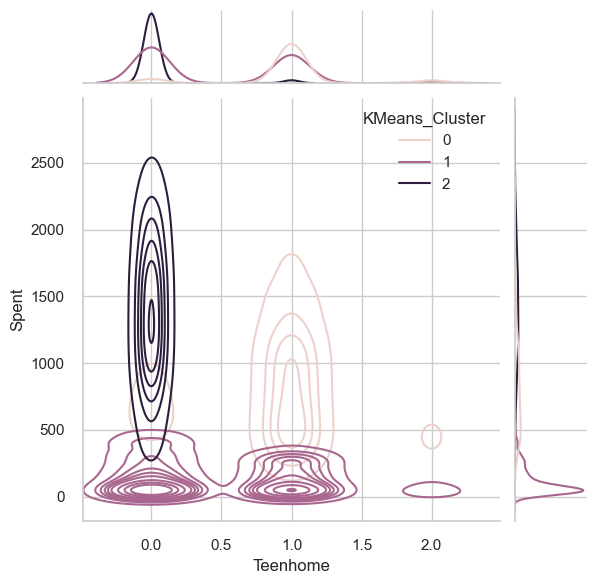

<Figure size 800x550 with 0 Axes>

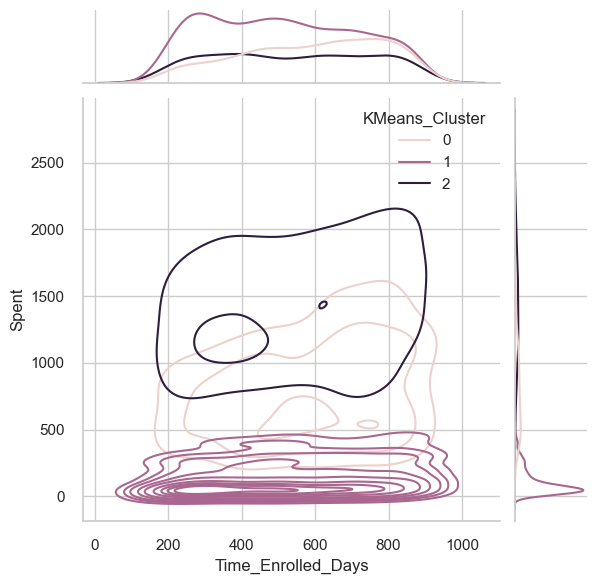

<Figure size 800x550 with 0 Axes>

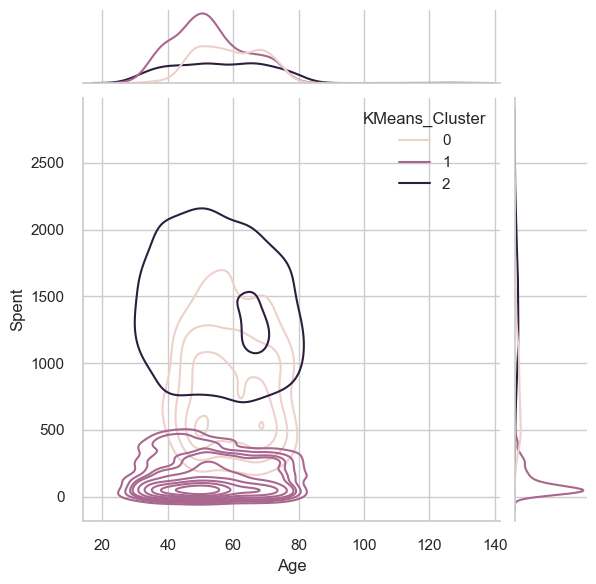

<Figure size 800x550 with 0 Axes>

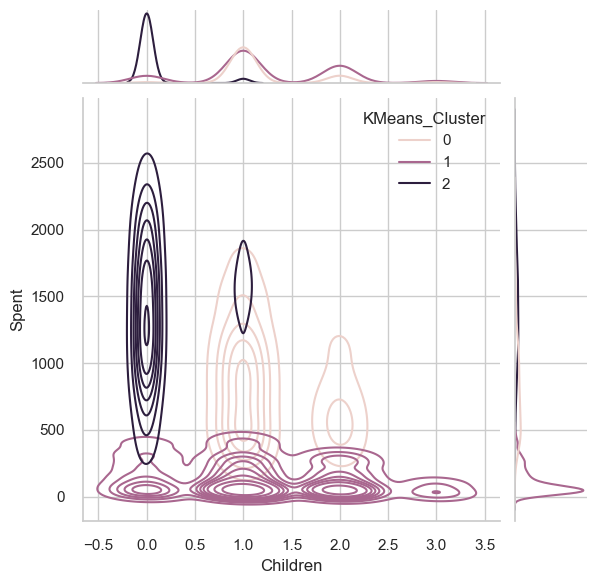

<Figure size 800x550 with 0 Axes>

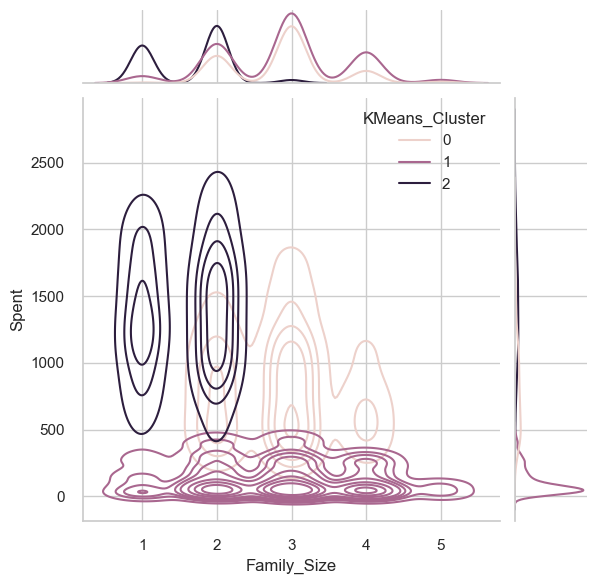

<Figure size 800x550 with 0 Axes>

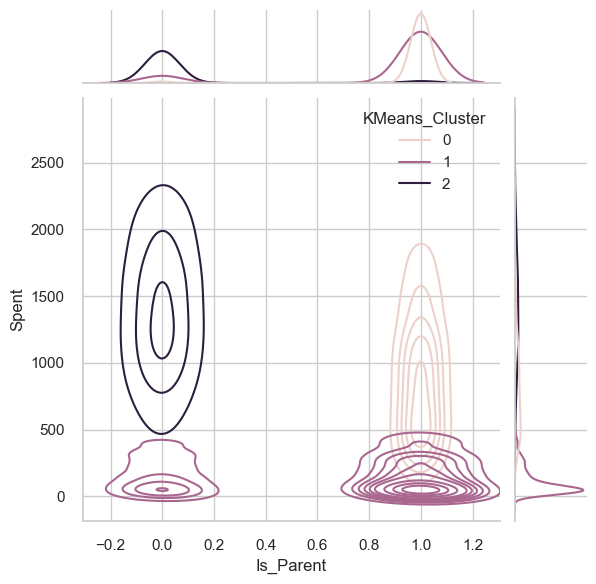

<Figure size 800x550 with 0 Axes>

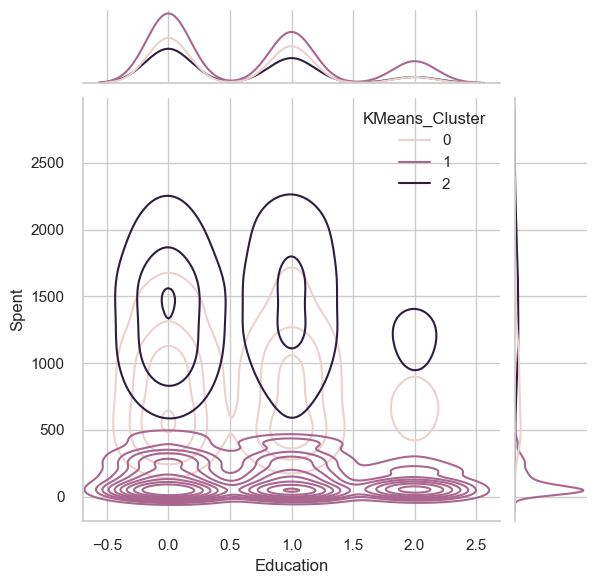

<Figure size 800x550 with 0 Axes>

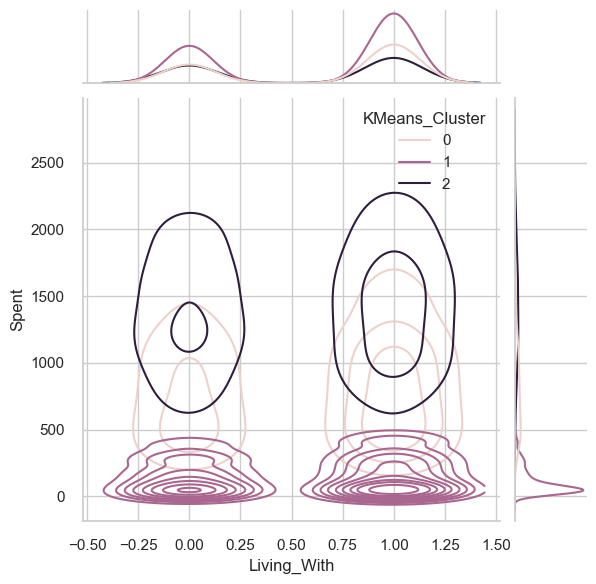

In [47]:
Personal = [ "Kidhome","Teenhome","Time_Enrolled_Days", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=customerdata[i], y=customerdata["Spent"], hue =customerdata["KMeans_Cluster"], kind="kde")
    plt.show()

# Cluster 0: Moderate Spenders with Minimal Family Size
# Cluster 1: Low Income, Low Spenders with Children
# Cluster 2: High Spenders with Small Family Size

Moderate Spenders with Minimal Family Size: This cluster likely represents individuals or households that spend a moderate amount of money on various expenses but have a smaller family size. They may not have as many dependents or financial responsibilities compared to other clusters.

Low Income, Low Spenders with Children: This cluster indicates individuals or families with low income who also tend to spend less money. However, despite their lower spending habits, they have children, suggesting that they may have additional financial burdens and responsibilities.

High Spenders with Small Family Size: This cluster comprises individuals or households that spend a significant amount of money and have a relatively small family size. They may have higher disposable income or prioritize spending on certain luxuries or high-cost items despite having fewer dependents.

# Model Building - KMeans

In [48]:
customerdata.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
       'Time_Enrolled_Days', 'Age', 'Spent', 'Living_With', 'Children',
       'Family_Size', 'Is_Parent', 'KMeans_Cluster'],
      dtype='object')

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score,precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

# Your data
X = customerdata.drop(columns=["KMeans_Cluster"])
y = customerdata['KMeans_Cluster']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Define your classifiers dictionary
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier()
}

In [52]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [53]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_proba, title):
    from sklearn.metrics import roc_curve, auc
    fpr = {}
    tpr = {}
    roc_auc = {}
    n_classes = y_proba.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {title}')
    plt.legend(loc="lower right")
    plt.show()

In [54]:
# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_proba, title):
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import average_precision_score
    precision = {}
    recall = {}
    average_precision = {}
    n_classes = y_proba.shape[1]

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_proba[:, i])
        average_precision[i] = average_precision_score(y_true == i, y_proba[:, i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], label=f'Class {i} (AP = {average_precision[i]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {title}')
    plt.legend(loc="lower right")
    plt.show()

Model Name: Logistic Regression
Accuracy: 0.88
AUC: 0.97
Mean Cross-Validation Score: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       133
           1       0.97      0.95      0.96       219
           2       0.81      0.77      0.79        95

    accuracy                           0.88       447
   macro avg       0.85      0.85      0.85       447
weighted avg       0.88      0.88      0.88       447

Confusion Matrix:
[[110   6  17]
 [ 10 209   0]
 [ 22   0  73]]
--------------------------------------------------
Evaluating Logistic Regression...


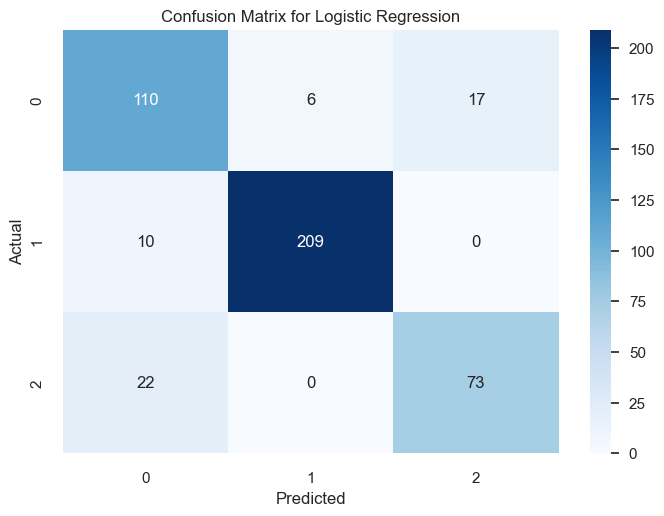

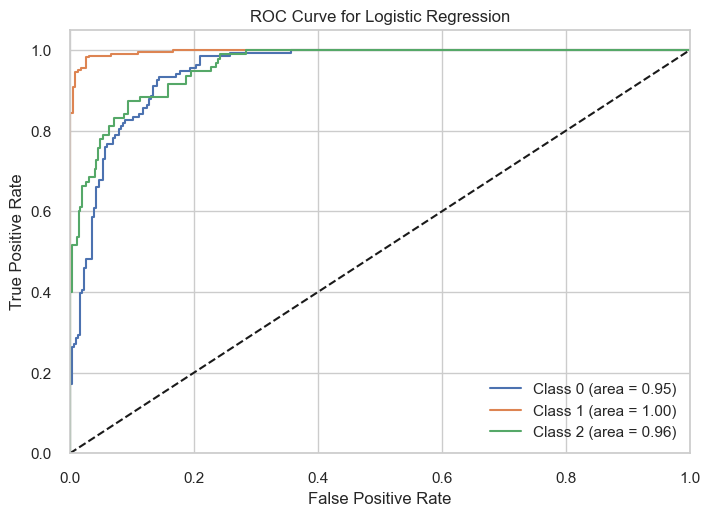

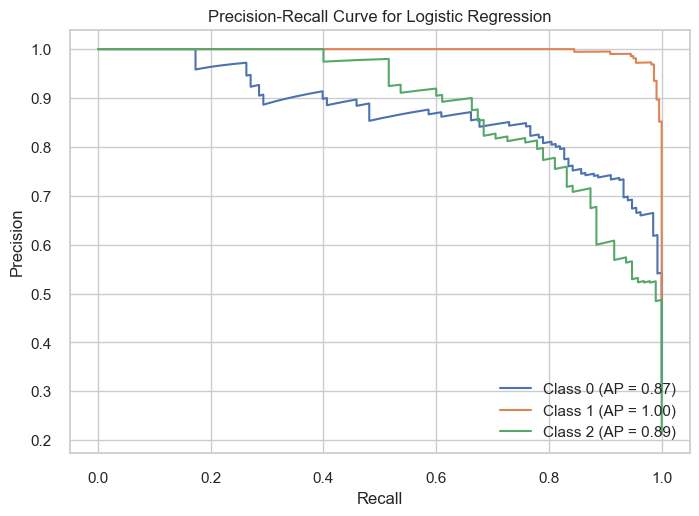

Model Name: Support Vector Machine
Accuracy: 0.79
AUC: 0.91
Mean Cross-Validation Score: 0.78
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68       133
           1       0.89      0.91      0.90       219
           2       0.74      0.60      0.66        95

    accuracy                           0.79       447
   macro avg       0.76      0.74      0.75       447
weighted avg       0.79      0.79      0.79       447

Confusion Matrix:
[[ 95  18  20]
 [ 19 200   0]
 [ 32   6  57]]
--------------------------------------------------
Evaluating Support Vector Machine...


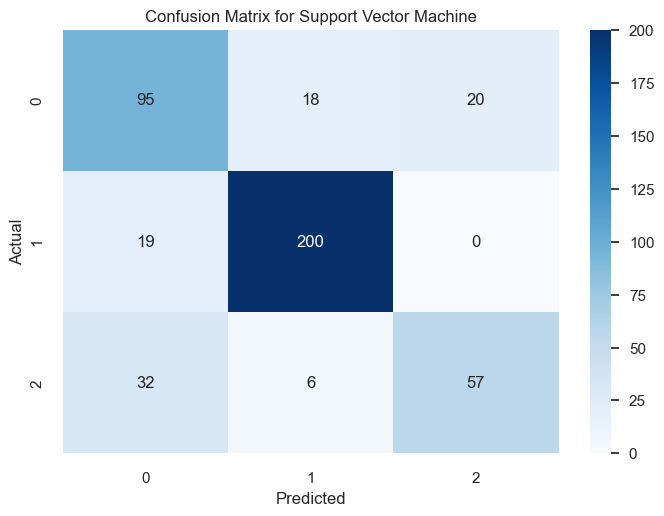

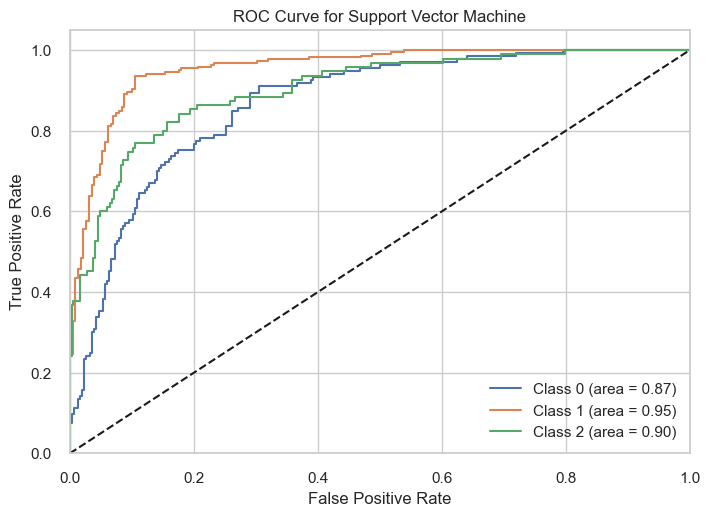

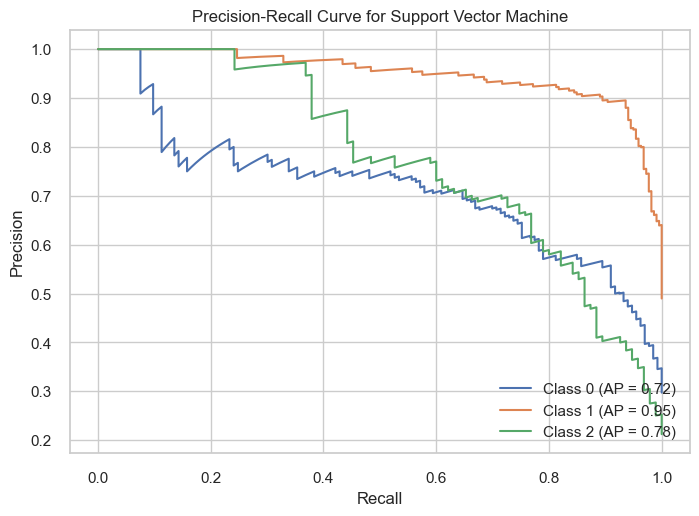

Model Name: Random Forest
Accuracy: 0.98
AUC: 1.00
Mean Cross-Validation Score: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       133
           1       0.99      0.99      0.99       219
           2       0.97      0.95      0.96        95

    accuracy                           0.98       447
   macro avg       0.97      0.97      0.97       447
weighted avg       0.98      0.98      0.98       447

Confusion Matrix:
[[130   1   2]
 [  2 216   1]
 [  4   1  90]]
--------------------------------------------------
Evaluating Random Forest...


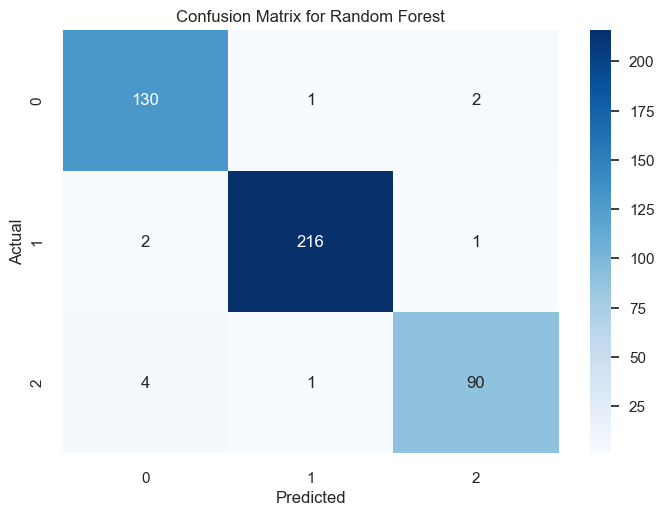

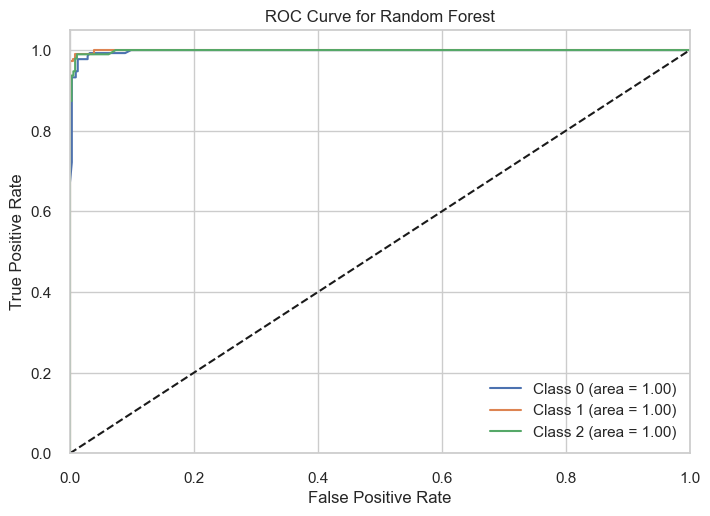

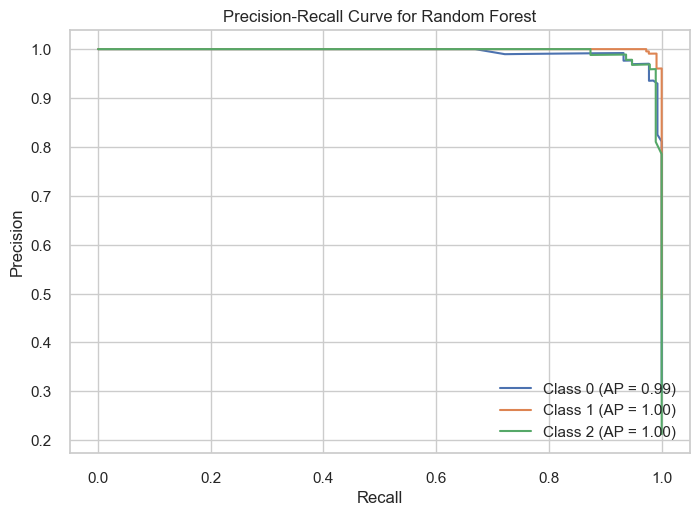

Model Name: Gradient Boosting
Accuracy: 0.98
AUC: 1.00
Mean Cross-Validation Score: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       133
           1       0.99      0.99      0.99       219
           2       0.99      0.95      0.97        95

    accuracy                           0.98       447
   macro avg       0.98      0.98      0.98       447
weighted avg       0.98      0.98      0.98       447

Confusion Matrix:
[[132   1   0]
 [  2 216   1]
 [  4   1  90]]
--------------------------------------------------
Evaluating Gradient Boosting...


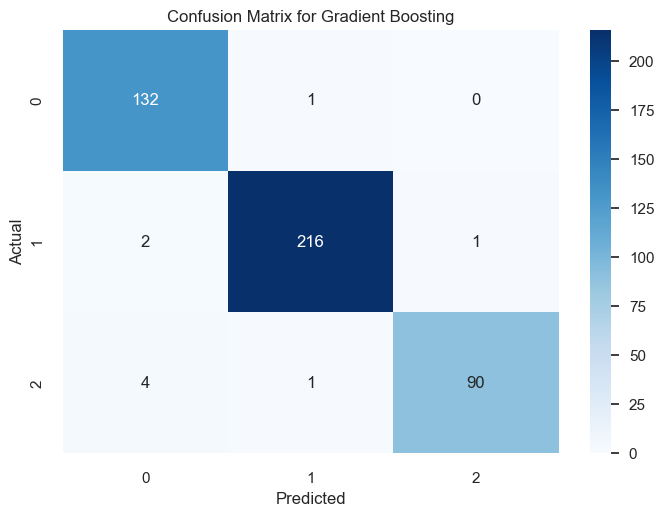

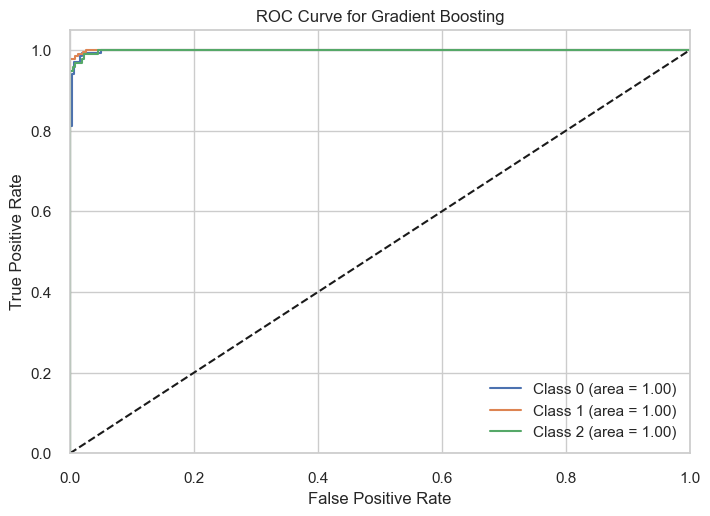

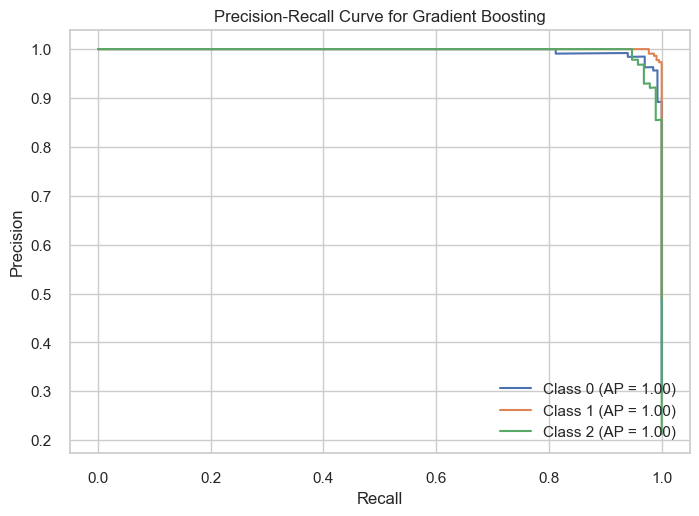

Model Name: K-Nearest Neighbors
Accuracy: 0.85
AUC: 0.94
Mean Cross-Validation Score: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       133
           1       0.93      0.96      0.95       219
           2       0.79      0.72      0.75        95

    accuracy                           0.85       447
   macro avg       0.83      0.82      0.82       447
weighted avg       0.85      0.85      0.85       447

Confusion Matrix:
[[102  13  18]
 [  8 211   0]
 [ 24   3  68]]
--------------------------------------------------
Evaluating K-Nearest Neighbors...


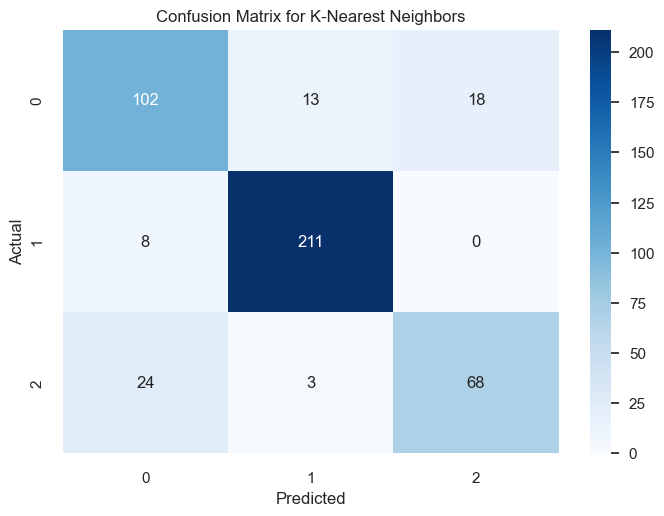

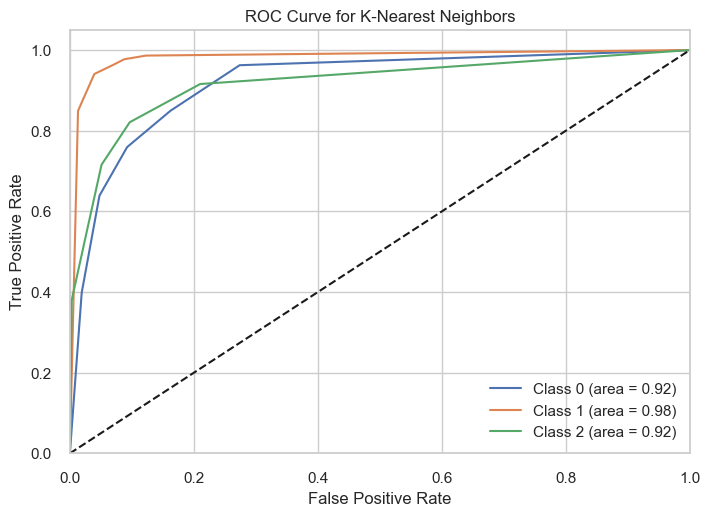

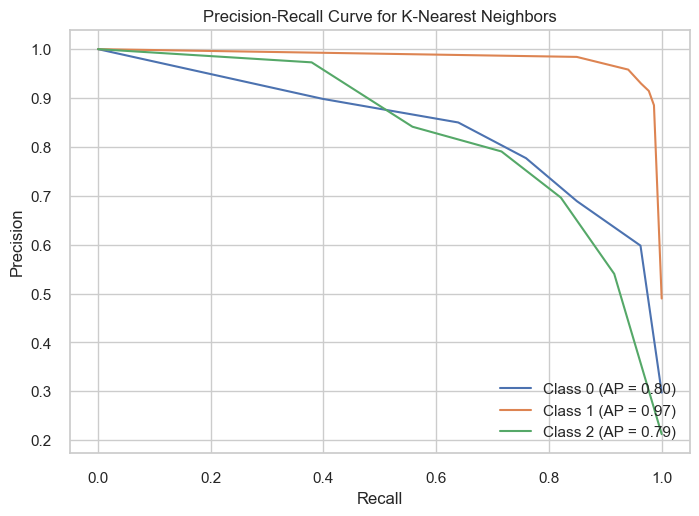

Model Name: Naive Bayes
Accuracy: 0.94
AUC: 0.99
Mean Cross-Validation Score: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       133
           1       1.00      0.96      0.98       219
           2       0.93      0.89      0.91        95

    accuracy                           0.94       447
   macro avg       0.93      0.94      0.93       447
weighted avg       0.95      0.94      0.94       447

Confusion Matrix:
[[127   0   6]
 [  9 210   0]
 [ 10   0  85]]
--------------------------------------------------
Evaluating Naive Bayes...


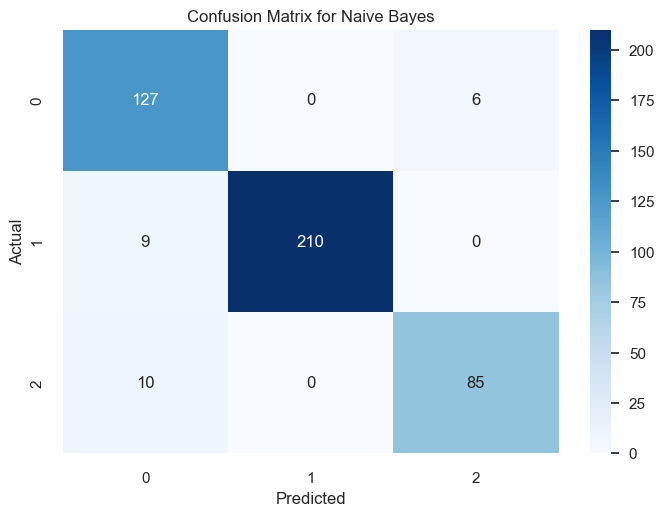

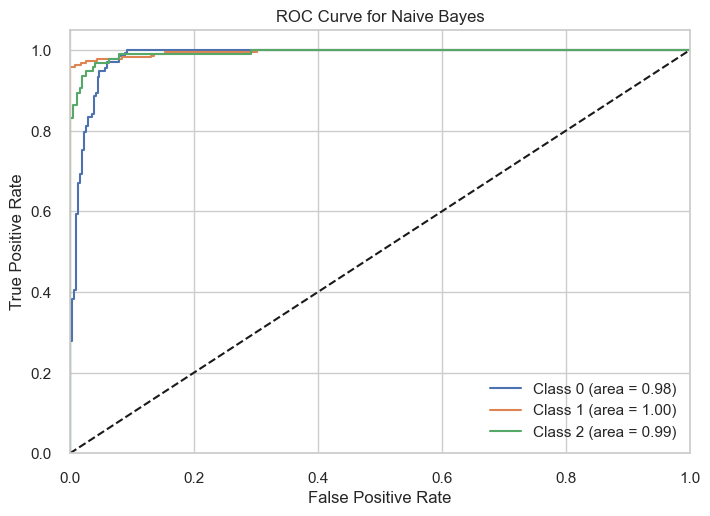

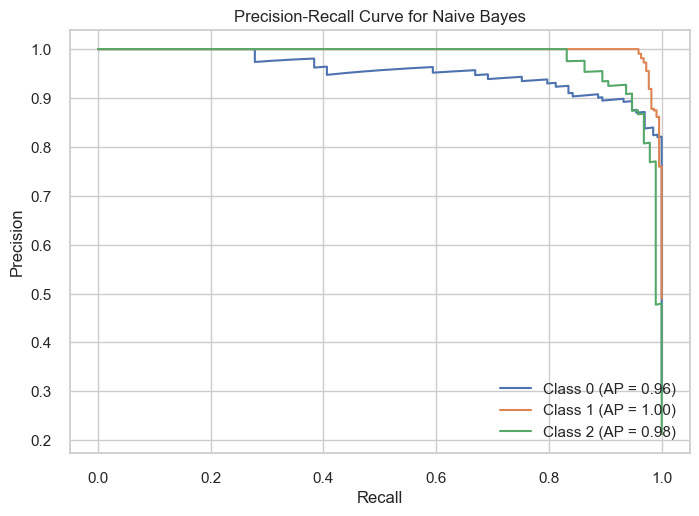

Model Name: Decision Tree
Accuracy: 0.97
AUC: 0.97
Mean Cross-Validation Score: 0.96
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       133
           1       0.99      0.99      0.99       219
           2       0.96      0.91      0.93        95

    accuracy                           0.97       447
   macro avg       0.96      0.96      0.96       447
weighted avg       0.97      0.97      0.97       447

Confusion Matrix:
[[129   1   3]
 [  1 217   1]
 [  8   1  86]]
--------------------------------------------------
Evaluating Decision Tree...


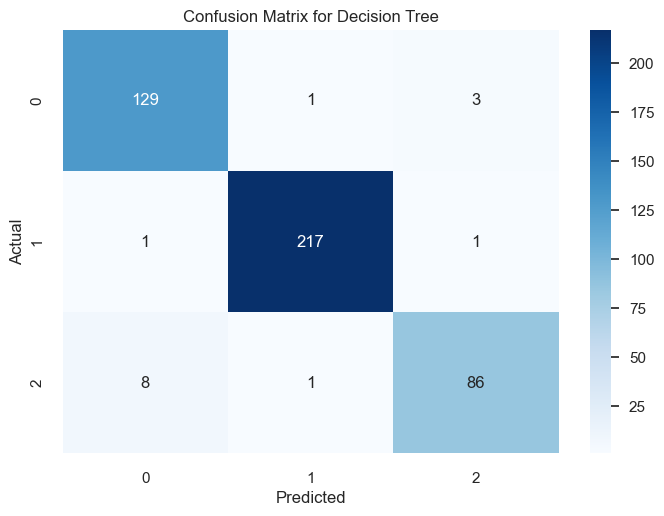

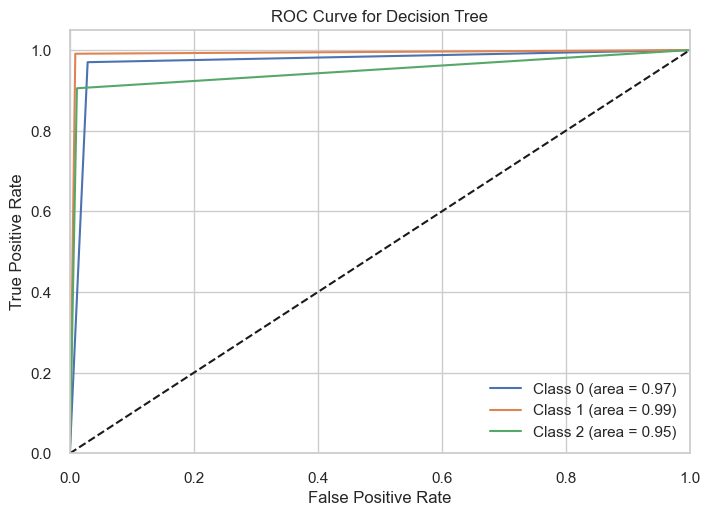

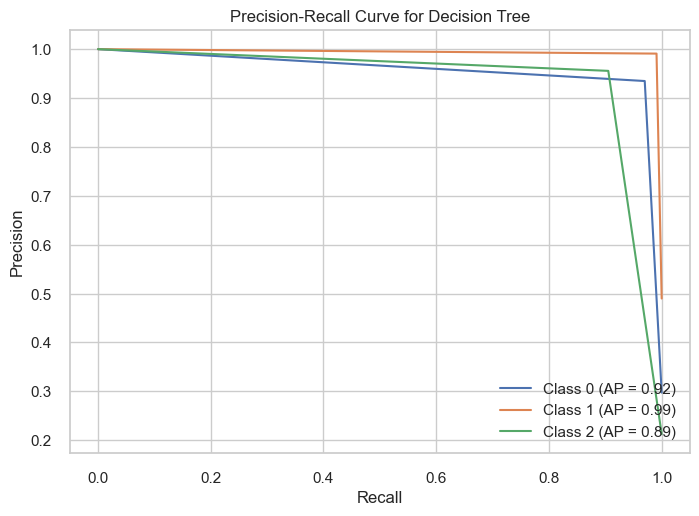

In [55]:
# List to collect model performance data
model_performance = []


# Fit and evaluate models
for model_name, model in classifiers.items():
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba, multi_class='ovr')
    cv_scores = cross_val_score(model, X, y, cv=5)
    
    print(f"\033[1mModel Name: {model_name}\033[0m")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"AUC: {auc_score:.2f}")
    print(f"Mean Cross-Validation Score: {cv_scores.mean():.2f}")
    print(f"Classification Report:\n{class_report}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print("--------------------------------------------------")
    
    # Add model performance to the list
    model_performance.append({'Model Name': model_name, 'Accuracy': accuracy, 'Mean Cross-Validation Score': cv_scores.mean()})
    
    print(f"\033[1mEvaluating {model_name}...\033[0m")
    plot_confusion_matrix(y_test, y_pred, model_name)
    plot_roc_curve(y_test, y_proba, model_name)
    plot_precision_recall_curve(y_test, y_proba, model_name)

In [57]:
# Create a DataFrame from the model performance list
performance_df = pd.DataFrame(model_performance)

# Sort the DataFrame by accuracy in descending order
performance_df = performance_df.sort_values(by='Mean Cross-Validation Score', ascending=False)

# Display the sorted DataFrame
performance_df["Accuracy"] = performance_df["Accuracy"].round(4)*100
performance_df["Mean Cross-Validation Score"] = performance_df["Mean Cross-Validation Score"].round(4)*100

print(performance_df)

               Model Name  Accuracy  Mean Cross-Validation Score
3       Gradient Boosting     97.99                        97.27
2           Random Forest     97.54                        96.64
6           Decision Tree     96.64                        95.52
5             Naive Bayes     94.41                        94.27
0     Logistic Regression     87.70                        87.59
4     K-Nearest Neighbors     85.23                        85.53
1  Support Vector Machine     78.75                        78.05


# Hence we will deploy model using Gradient Boosting classifier as Three clusters technique giving 97% accuracy.

In [58]:
#pip install scikit-learn pandas joblib

In [59]:
customerdata.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
       'Time_Enrolled_Days', 'Age', 'Spent', 'Living_With', 'Children',
       'Family_Size', 'Is_Parent', 'KMeans_Cluster'],
      dtype='object')

In [60]:
# Train KMeans clustering model
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=3, random_state=42)

In [61]:
# Predict KMeans cluster
cluster_labels_kmeans = kmeans.predict(X_scaled)

In [62]:
# Add cluster labels to the original dataset
customerdata['KMeans_Cluster'] = cluster_labels_kmeans

In [63]:
customerdata.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
       'Time_Enrolled_Days', 'Age', 'Spent', 'Living_With', 'Children',
       'Family_Size', 'Is_Parent', 'KMeans_Cluster'],
      dtype='object')

In [64]:
from sklearn.ensemble import GradientBoostingClassifier
# Specify your feature columns and target column
X = X_scaled
y = customerdata['KMeans_Cluster']
gb_model = GradientBoostingClassifier()
gb_model.fit(X_scaled, y)

GradientBoostingClassifier()

In [65]:
import joblib
# Save the models
joblib.dump(kmeans, "kmeans_model.pkl")
joblib.dump(gb_model, "gradient_boosting_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']